<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem, beta

import pylab as plt

### Optener y preparar dados

In [2]:
game = pd.read_csv('data/cookie_cats.csv')

game.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
pd.crosstab(game.version, game.retention_1)


retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


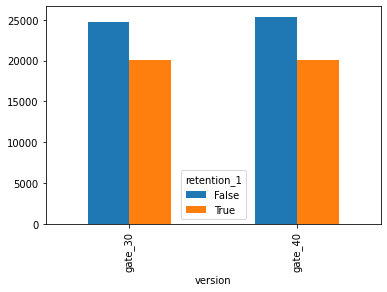

In [5]:
pd.crosstab(game.version, game.retention_1).plot(kind='bar');

## AB Testing Bayesiano

#### Retencion en día 1

In [6]:
control = game[game.version == 'gate_30']
test = game[game.version == 'gate_40'] 

imps_ctrl, convs_ctrl = len(control), len(control[control.retention_1 == True])   # entrar, comprar
imps_test, convs_test= len(test), len(test[test.retention_1 == True])


CR_ctrl=convs_ctrl/imps_ctrl
CR_test=convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [7]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [8]:
x=np.linspace(0.43, 0.46, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

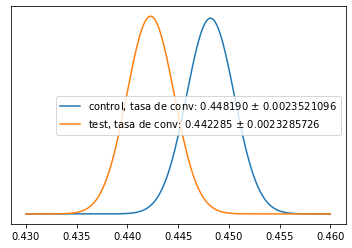

In [9]:
plot([beta_control, beta_test], ['control', 'test'])

In [10]:
salto=(beta_test.mean()-beta_control.mean())/beta_control.mean()
salto

-0.013175098158249857

In [11]:
prob = 1 - beta_control.cdf(0.44524) # Integral para sacar el área


In [12]:
'''El test disminuye la tasa de retencion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test disminuye la tasa de retencion en un -1.32%, con una probabilidad del 89.52%'

#### Retencion en día 7

In [13]:
control = game[game.version == 'gate_30']
test = game[game.version == 'gate_40'] 

imps_ctrl, convs_ctrl = len(control), len(control[control.retention_7 == True])   # entrar, comprar
imps_test, convs_test= len(test), len(test[test.retention_7 == True])


CR_ctrl=convs_ctrl/imps_ctrl
CR_test=convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [14]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [15]:
x=np.linspace(0.175, 0.195, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

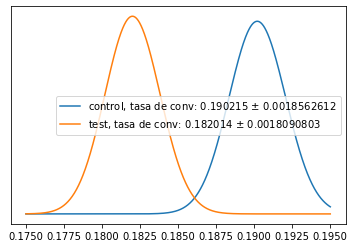

In [16]:
plot([beta_control, beta_test], ['control', 'test'])

In [17]:
salto=(beta_test.mean()-beta_control.mean())/beta_control.mean()
salto

-0.04311526114658881

In [18]:
prob = 1 - beta_control.cdf(0.18606) # Integral para sacar el área


In [19]:
'''El test disminuye la tasa de retencion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test disminuye la tasa de retencion en un -4.31%, con una probabilidad del 98.77%'